In [1]:
import numpy as np
from tnestmodel.datasets import datasets
from tnestmodel.temp_wl import compute_d_rounds
from tnestmodel.temp_fast_graph import SparseTempFastGraph
from nestmodel.graph_properties import number_of_flips_possible
import matplotlib.pyplot as plt

In [2]:
use_range_times = True

In [3]:
def switch_in_out(E):
    out = np.empty_like(E)
    out[:,0] = E[:,1]
    out[:,1] = E[:,0]
    out[:,2] = E[:,2]
    return out

In [4]:
Gs = []
time_deltas = []
hs = []
for dataset in datasets:
    print()
    print(dataset.name)
    E = dataset.read_edges()
    if dataset.is_directed:
        E = switch_in_out(E)

    nodes = np.unique(E[:, :2].ravel())
    total_time_diff = np.max(E[:,2])-np.min(E[:,2])
    time_deltas.append(total_time_diff)
    h2 = int(round(total_time_diff*0.2))

    G = SparseTempFastGraph.from_temporal_edges(E, dataset.is_directed)
    if use_range_times:
        G.times = np.arange(len(G.times))
        h2 = int(round(len(G.times*0.2)))
    G.assign_colors_to_slices(h=h2)
        
    hs.append(h2)
    Gs.append(G)
    



opsahl
max_d 5

email-eu2
max_d 5

email-eu3
max_d 5

dnc
max_d 5

highschool_2011
max_d 5

hospital_ward
max_d 4

ht09
max_d 5

workplace_2013
max_d 5


In [5]:
from numpy.testing import assert_array_equal

In [6]:
for G in Gs:
    for d_iter in range(len(G.slices[0].base_partitions)):
        G.s.reset_colors(d_iter, G.h, mode="global")
        print(d_iter)
        for t, G_t in zip(G.times,G.slices):
            G.s.advance_time(t)
            #print(G.s.current_colors[G_t.global_nodes], G_t.base_partitions[d_iter])
            assert_array_equal(G.s.current_colors[G_t.global_nodes], G_t.base_partitions[d_iter])


0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
0
1
2
3
4
0
1
2
3
4


In [7]:
from numba.typed import Dict
from numba import njit


In [8]:
from nestmodel.graph_properties import _source_only_number_of_flips_possible, _normal_number_of_flips_possible

#@njit(cache=True)
def update_color_counts(affected_nodes, last_colors, new_colors, number_of_nodes_per_color):
    for node in affected_nodes:
        old_color = last_colors[node]
        new_color = new_colors[node]
        if old_color==new_color:
            continue
        # remove old color from count
        if number_of_nodes_per_color[old_color] == 1:
            del number_of_nodes_per_color[old_color]
        else:
            number_of_nodes_per_color[old_color]-=1
        # add new color to count
        if new_color in number_of_nodes_per_color:
            number_of_nodes_per_color[new_color]+=1
        else:
            number_of_nodes_per_color[new_color]=1
        last_colors[node] = new_color
    


class NumberOfFlipsCalculator():
    def __init__(self, G_temp, h, s = None):
        self.G_temp = G_temp
        self.h = h
        if s is None:
            self.struct = G_temp.s#get_temporal_wl_struct(h=h, base_edges=True)
        else:
            self.struct = s
        if G_temp.is_directed:
            self.last_colors = np.zeros(G_temp.num_nodes, dtype=np.int64) # assumes degree zero nodes have color zero!
            self.number_of_nodes_per_color = Dict()
            self.number_of_nodes_per_color[0] = G_temp.num_nodes
        else:
            self.last_colors = None
            self.number_of_nodes_per_color = None
        
        
        self.d = None
            
    def prepare(self, d):
        self.d = d
        self.struct.reset_colors(d=d, h=self.h, mode="global")
        if self.G_temp.is_directed:
            self.last_colors[:]=0
            self.number_of_nodes_per_color.clear()
            self.number_of_nodes_per_color[0] = self.G_temp.num_nodes
        
    def calc_for_slice(self, G, t):
        if self.G_temp.is_directed:
            affected_nodes = self.struct.advance_time(t)
            #print(G.global_edges, affected_nodes)
            affected_nodes = np.fromiter(affected_nodes, count = len(affected_nodes), dtype=np.int64)
            #print("current_colors", self.struct.current_colors[G.global_nodes])
            #print("set     colors", G.base_partitions[self.d])
            assert_array_equal(self.struct.current_colors[G.global_nodes], G.base_partitions[self.d])
            update_color_counts(affected_nodes, self.last_colors, self.struct.current_colors, self.number_of_nodes_per_color)
            return _source_only_number_of_flips_possible(G, self.d, self.number_of_nodes_per_color)
        else:
            return _normal_number_of_flips_possible(G, d)

In [9]:
from nestmodel.graph_properties import block_sizes, sum_degrees_at_endpoints, count_mono_color_edges
from nestmodel.fast_graph import FastGraph
from numpy.testing import assert_array_equal

def _source_only_number_of_flips_possible(G : FastGraph, d: int, num_nodes_by_class : Dict=None, partition=None):
    """Compute the number of flips for a directed graph and the source only strategy"""

    degrees_sum = sum_degrees_at_endpoints(G.edges, G.num_nodes, G.block_indices[d], source=False)
    if partition is None:
        partition = G.base_partitions[d]
    if num_nodes_by_class is None:
        num_nodes_by_class = count_nodes_by_color_class(partition)
    try:
        num_nodes = count_source_node_per_block(G.edges, partition, num_nodes_by_class, G.block_indices[d])
    except:
        print(G.base_partitions)
        print(G.global_nodes)
    #print("partitions", G.base_partitions)
    #print(G.block_indices[d])
    num_edges = block_sizes(G.block_indices[d])
    #print(num_nodes)
    #print(num_edges)
    block_squared_sum = np.inner(num_nodes, num_edges)
    num_mono_colored = count_mono_color_edges(G.edges, partition, G.block_indices[d])
    #print(block_squared_sum)
    #print("degrees_sum", degrees_sum)
    #print(num_mono_colored)
    final_value = (block_squared_sum - degrees_sum - num_mono_colored)
    return final_value

In [10]:
def count_source_node_per_block(E, partition, number_of_nodes_by_class, block_indices):
    """Counts the number of nodes with the same color as the source for each block"""
    num_nodes = np.empty(len(block_indices), dtype=np.int64)
    for i in range(len(block_indices)):
        start = block_indices[i,0]
        stop = block_indices[i,1]
        source_node = E[start,0]
        target_node = E[start,1]
        source_color = partition[source_node]
        target_color = partition[source_node]
        #try:
        num_other_nodes_with_color = number_of_nodes_by_class[np.int64(source_color)]
        #except:
            #print(partition)
            #print(number_of_nodes_by_class)
            #print(source_color)
         #   raise ValueError()

        num_nodes[i] = num_other_nodes_with_color
    return num_nodes

In [11]:
ts = []
arrs = []
for h, G in zip(hs, Gs):
    print("A")
    d_max = len(G.slices[0].base_partitions)
    total_arr = np.zeros((len(G.slices), d_max), dtype=np.int64)
    #h = time_delta * 0.2
    calculator = NumberOfFlipsCalculator(G, h)
    for d in range(0, d_max):
        print("<<< depth", d)
        calculator.prepare(d)
        t, arr = G.compute_for_each_slice(calculator.calc_for_slice, min_size=1, call_with_time=True)
        total_arr[:,d]=arr
    t = np.array(t, dtype=np.float64)
    t = t-t.min()
    t /= t.max()
    ts.append(t)
    arrs.append(total_arr)

A
<<< depth 0
<<< depth 1
<<< depth 2
<<< depth 3
<<< depth 4
A
<<< depth 0
<<< depth 1
<<< depth 2
<<< depth 3
<<< depth 4
A
<<< depth 0
<<< depth 1
<<< depth 2
<<< depth 3
<<< depth 4
A
<<< depth 0
<<< depth 1
<<< depth 2
<<< depth 3
<<< depth 4
A
<<< depth 0
<<< depth 1
<<< depth 2
<<< depth 3
<<< depth 4
A
<<< depth 0
<<< depth 1
<<< depth 2
<<< depth 3
A
<<< depth 0
<<< depth 1
<<< depth 2
<<< depth 3
<<< depth 4
A
<<< depth 0
<<< depth 1
<<< depth 2
<<< depth 3
<<< depth 4


In [12]:
print(G.h, h)

7104 7104


In [13]:
#current_colors [313 247]
#set     colors [310 247]

In [14]:
def number_of_edges(G):
    return len(G.edges)

In [15]:
num_edges_per_slice = []
for G in Gs:
    t, arr = G.compute_for_each_slice(number_of_edges, min_size=1, call_with_time=False)
    num_edges_per_slice.append(arr)

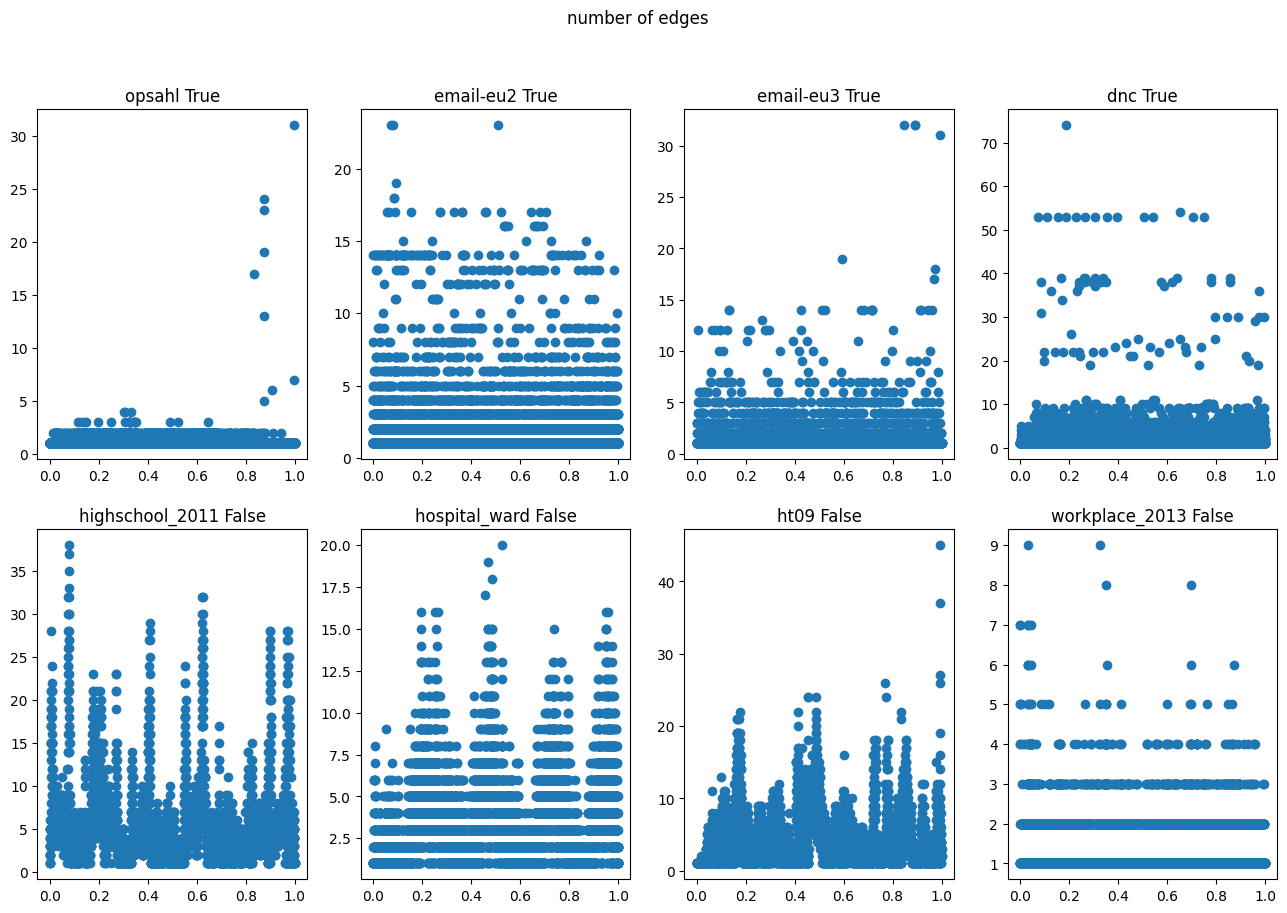

In [16]:
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(16,10))
fig.suptitle("number of edges")
axs = axs.ravel()
for ax, dataset, t, arr in zip(axs, datasets, ts, num_edges_per_slice):
    ax.scatter(t, arr)
    ax.set_title(dataset.name+" "+str(dataset.is_directed))
        #print(dataset.name)
        #print(arr[:,0].min())
plt.show()

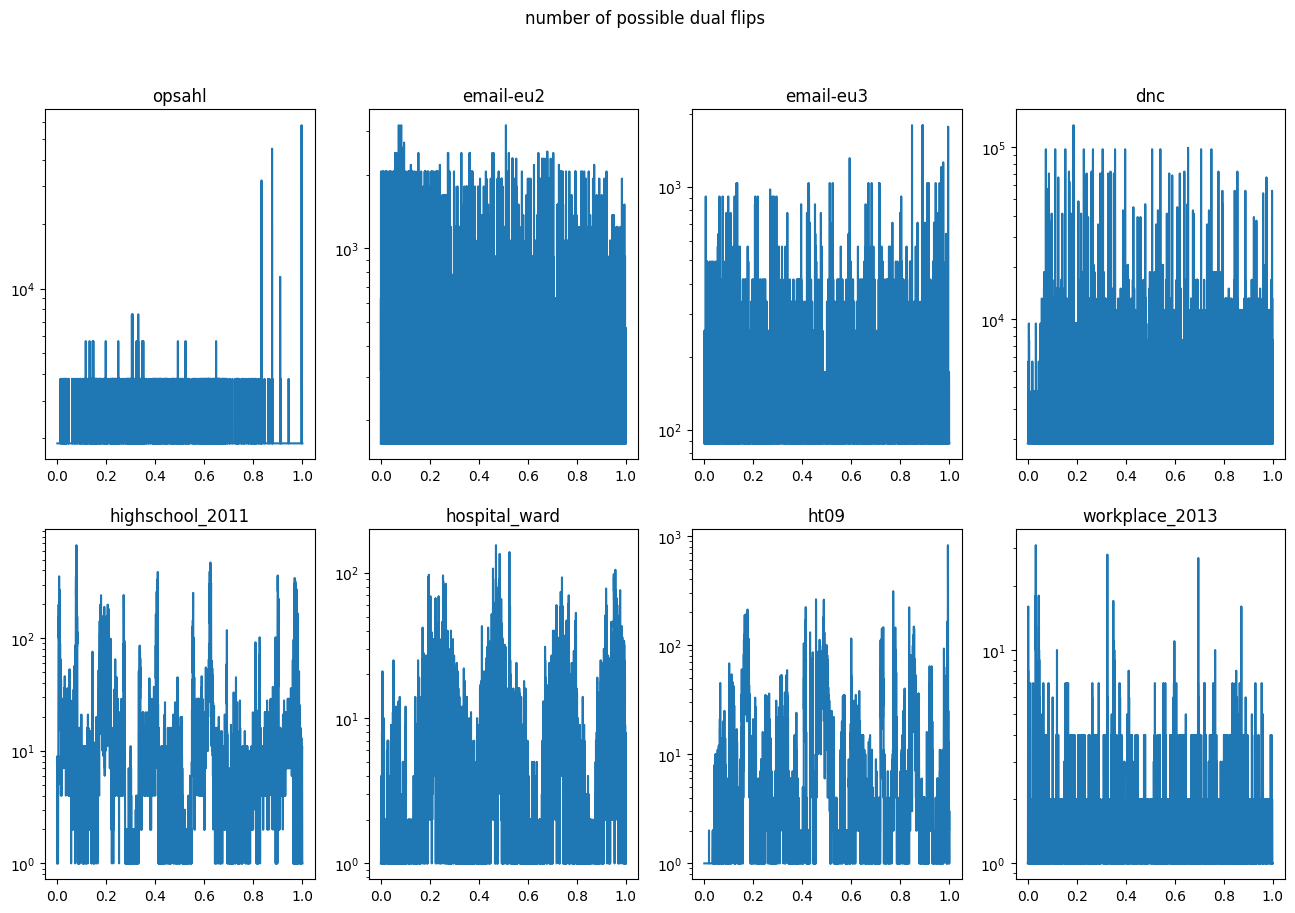

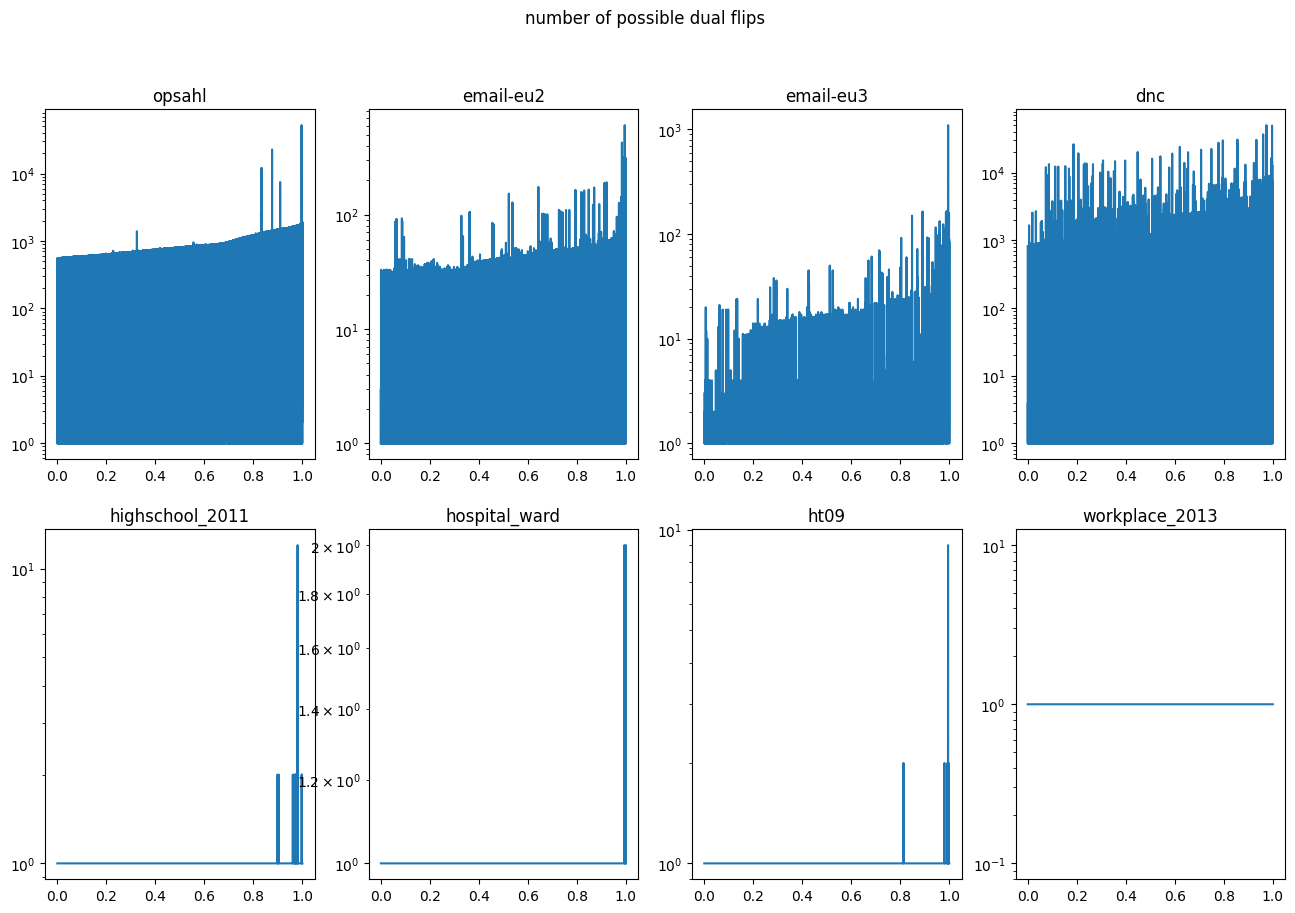

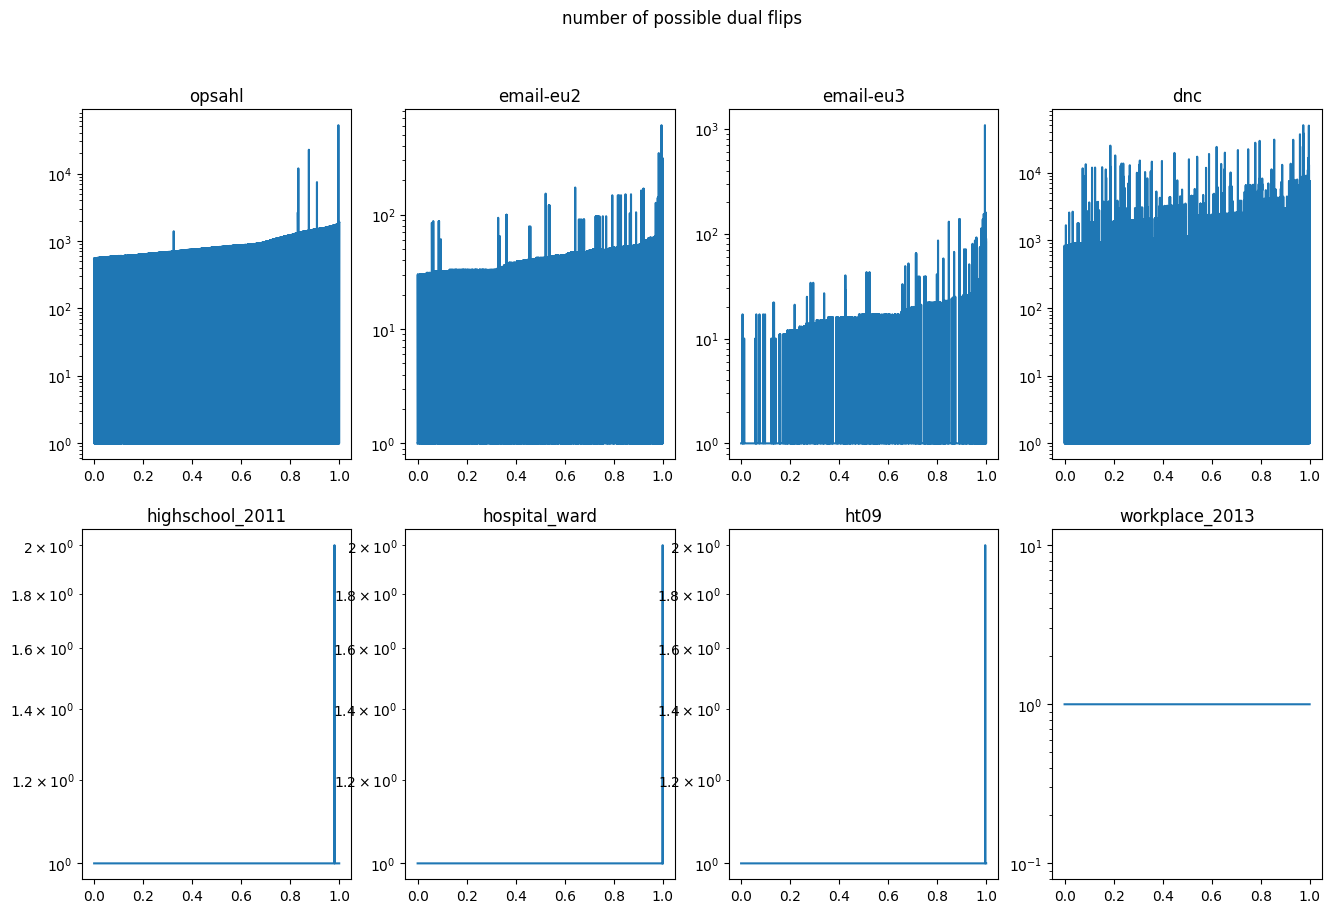

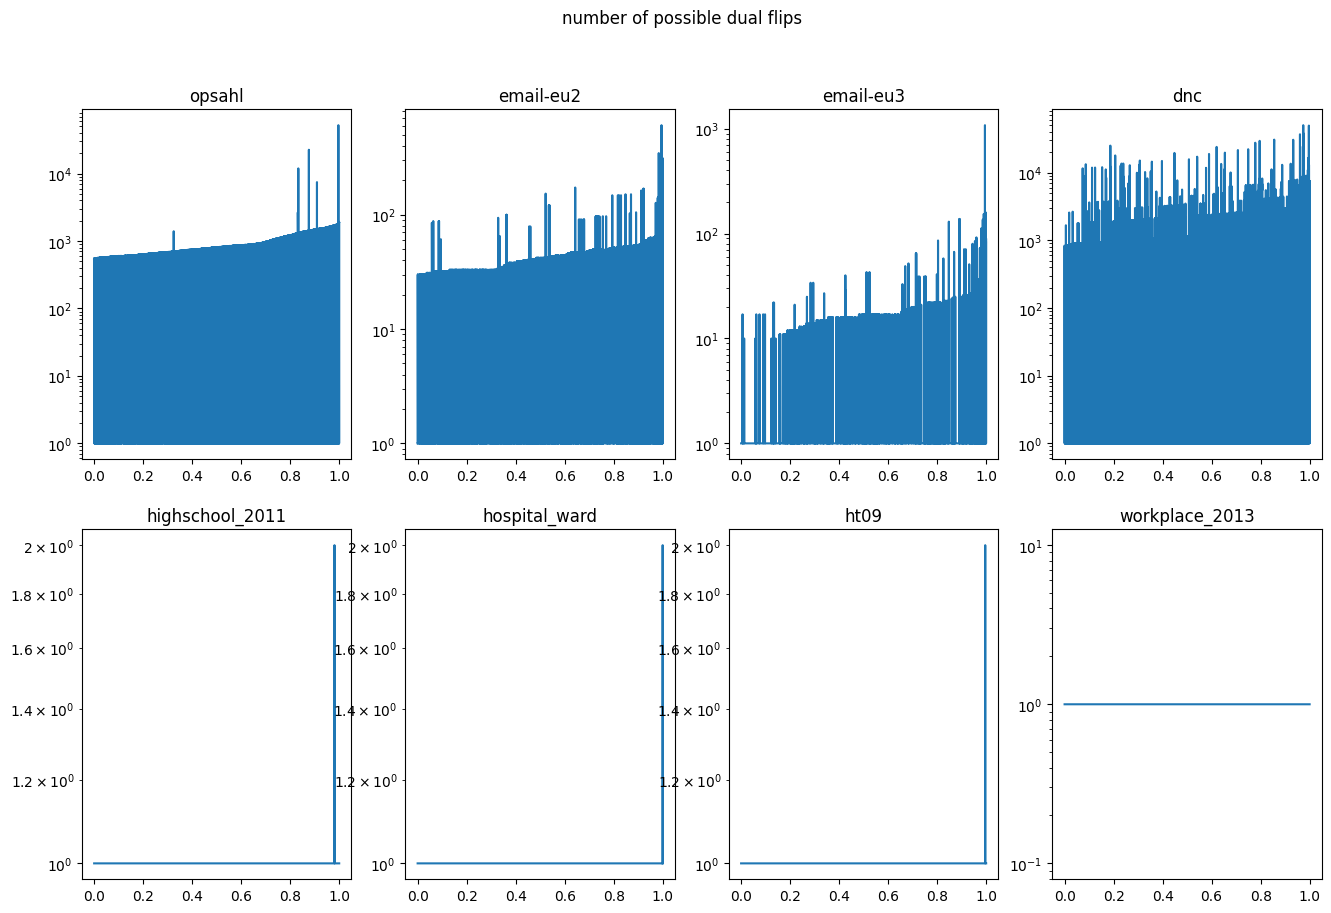

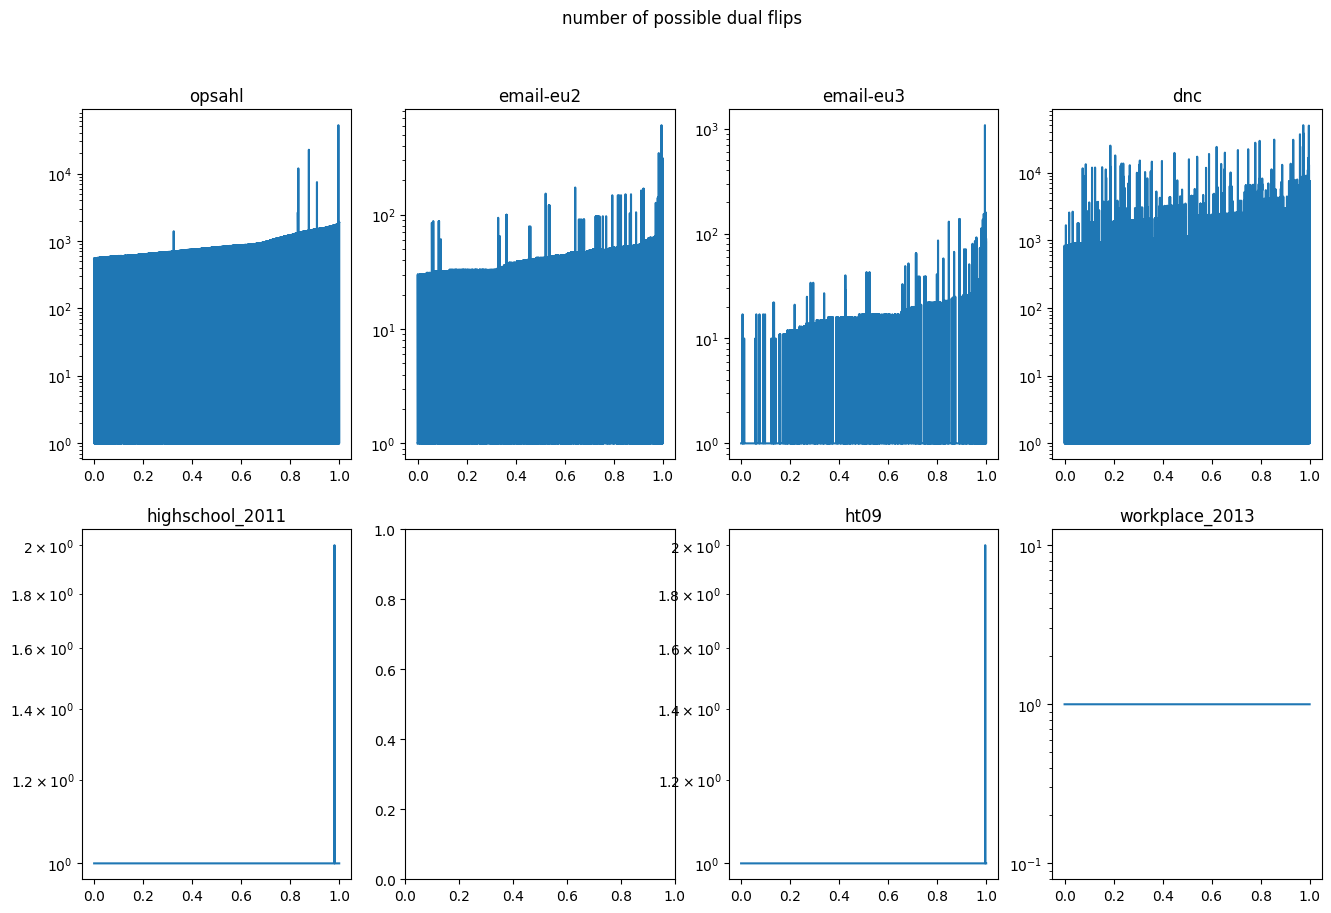

In [24]:
max_depth = max([len(x.slices[0].base_partitions) for x in Gs])


for d in range(max_depth):
    fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(16,10))
    fig.suptitle("number of possible dual flips")
    axs = axs.ravel()
    for ax, dataset, t, arr in zip(axs, datasets, ts, arrs):
        if arr.shape[1]>d:
            ax.plot(t, arr[:,d]+1)
            ax.set_title(dataset.name)
            ax.set_yscale("log")
            #print(dataset.name)
            #print(arr[:,0].min())
    plt.show()

In [18]:
np.max(arrs[0][:,0]-arrs[0][:,1])

25951

In [19]:
np.all(arrs[0][:,0]-arrs[0][:,1]>=0)

True

In [20]:
np.max(arrs[0][:,1]-arrs[0][:,3])

270